<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/02_BasicMLAlgorithms/examples/classification%20-%20fifa-man-of-the-match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees Hands On

The data has been collected from 2018 FIFA World Cup Russia Official App.

https://www.kaggle.com/mathan/fifa-2018-match-statistics

Attributes:
- Date: Match Date
- Team: Playing Team
- Opponent: Opponent Team
- Goal Scored: Number of goals scored by this team
- Ball Possession %: Amount of time ball was in control by the team
- Attempts: Number of attempts to score goal
- On-Target: Number of shots on-target
- Off-Target: Number of shots that went off-target
- Blocked: Number of opponent team's attempts blocked by the team
- Corners: Number of corner shots used
- Offsides: Number of off-side events
- Free Kicks: Number of free-kicks used
- Saves: Number saves by the goal keeper
- Pass Accuracy %: Percentage of passes that reached the same team player as aimed
- Passes: Total number of passes by the team
- Distance Covered (Kms): Total distance covered by the team members in this game
- Fouls Committed: Number of fouls committed by the team members
- Yellow Card: Number of Yellow warning received
- Yellow & Red: Number of Yellow & Red warning received
- Red: Number of Red cards received
- 1st Goal: When did the team score the 1st goal?
- Round: Stage of the match
- PSO: Was there a penalty shootout (PSO) in this match?
- Goals in PSO: Number of goals scored in the Penalty shootout
- Own goals: Number of own goals
- Own goal Time: When did the team score own goal?


Target:
- Man of the Match: Which team won Man of the Match for a given game?

In [1]:
# https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly
!pip install matplotlib==3.1.0

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# data engineering
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer

# feature engineering
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# classification
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [3]:
# We are relying on some newer features of sklearn (OneHotEncoder), 
# so check what version we have installed (need 0.21)
import sklearn
sklearn.__version__

'0.21.3'

In [4]:
csv_path = 'https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/fifa-2018-match-statistics/FIFA%202018%20Statistics_train.csv'
test_csv_path = 'https://raw.githubusercontent.com/lisaong/mldds-courseware/master/data/fifa-2018-match-statistics/FIFA%202018%20Statistics_test.csv'

df = pd.read_csv(csv_path)
df.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


In [5]:
df.columns

Index(['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %',
       'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

In [0]:
target = 'Man of the Match'

# - Target is excluded from features
# - Date is not considered an influencing factor in winning Man of the Match, so we are excluding it from features
# - Round has some issues with encoding because the test and train set have different values. To fix that, need to shuffle the test and training set

features = (df.columns != target) & (df.columns != 'Date') & (df.columns != 'Round')

## Data Engineering

- Clean NaN values
- Scale features
- One-hot Encode features
- Plot PCA
- Check for Imbalance

We will see how to package everything in to a Pipeline, using Transformers.
This is useful when there are multiple sets of data (e.g. separate train, test datasets), and we want to ensure that we streamline processing the same way.

In [7]:
# inspect features
df.loc[:, features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 24 columns):
Team                      120 non-null object
Opponent                  120 non-null object
Goal Scored               120 non-null int64
Ball Possession %         120 non-null int64
Attempts                  120 non-null int64
On-Target                 120 non-null int64
Off-Target                120 non-null int64
Blocked                   120 non-null int64
Corners                   120 non-null int64
Offsides                  120 non-null int64
Free Kicks                120 non-null int64
Saves                     120 non-null int64
Pass Accuracy %           120 non-null int64
Passes                    120 non-null int64
Distance Covered (Kms)    120 non-null int64
Fouls Committed           120 non-null int64
Yellow Card               120 non-null int64
Yellow & Red              120 non-null int64
Red                       120 non-null int64
1st Goal                  88 non-null 

In [8]:
# Inspect NaN values
df['1st Goal'].unique()

array([12., nan, 89., 90.,  4., 24., 58., 62., 19., 23., 59., 32., 56.,
       35., 20., 50., 65., 47., 11., 39.,  6., 37., 60., 54.,  7., 38.,
       34., 53., 49.,  5., 52., 18., 26., 48.,  8., 78., 40., 10., 45.,
       22., 14., 51., 76., 36., 31., 74., 33., 13., 41., 55.,  1., 69.,
       66., 57., 30.])

In [9]:
mask = df['1st Goal'].isna() # True for rows that have 1st Goal NaN
df[mask] # Subset of df where mask is True

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0
12,16-06-2018,Peru,Denmark,0,52,18,6,7,5,3,5,21,2,85,394,104,10,1,0,0,No,NaN,Group Stage,No,0,NaN,NaN
15,17-06-2018,Nigeria,Croatia,0,46,14,2,5,7,5,1,22,1,84,388,101,16,1,0,0,No,NaN,Group Stage,No,0,1.0,32.0
16,17-06-2018,Costa Rica,Serbia,0,50,10,3,3,4,5,1,18,2,83,428,107,18,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
18,17-06-2018,Germany,Mexico,0,60,25,9,9,7,8,1,17,3,88,595,110,10,2,0,0,Yes,NaN,Group Stage,No,0,NaN,NaN
23,18-06-2018,Korea Republic,Sweden,0,48,5,0,2,3,5,0,21,3,79,351,103,23,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
25,18-06-2018,Panama,Belgium,0,39,6,2,4,0,3,3,18,2,82,317,100,18,5,0,0,No,NaN,Group Stage,No,0,NaN,NaN
35,20-06-2018,Morocco,Portugal,0,53,16,4,10,2,7,1,20,1,77,466,107,23,1,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [0]:
# 1st Goal [12. nan 89. 90.  4. 24. 58. 62. 19. ...
df['1st Goal'].fillna(-1, inplace=True)

In [11]:
# Inspect NaN values
df['Own goals'].unique()

array([nan,  1.])

In [0]:
# Own goals [nan  1.]
df['Own goals'].fillna(0, inplace=True)

In [13]:
# Inspect NaN values
df['Own goal Time'].unique()

array([nan, 90., 81., 32., 37., 47., 23., 74., 33., 12., 13.])

In [0]:
# Own goal Time [nan 90. 81. 32. 37. 47. 23. 74. 33. 12. 13. 18.]
df['Own goal Time'].fillna(-1, inplace=True)

In [15]:
# check that we've filled all the NaNs
df.loc[:, features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 24 columns):
Team                      120 non-null object
Opponent                  120 non-null object
Goal Scored               120 non-null int64
Ball Possession %         120 non-null int64
Attempts                  120 non-null int64
On-Target                 120 non-null int64
Off-Target                120 non-null int64
Blocked                   120 non-null int64
Corners                   120 non-null int64
Offsides                  120 non-null int64
Free Kicks                120 non-null int64
Saves                     120 non-null int64
Pass Accuracy %           120 non-null int64
Passes                    120 non-null int64
Distance Covered (Kms)    120 non-null int64
Fouls Committed           120 non-null int64
Yellow Card               120 non-null int64
Yellow & Red              120 non-null int64
Red                       120 non-null int64
1st Goal                  120 non-null

### Function Transformer

- Useful way to package the cleaning steps for use later in a scikit-learn Pipeline
- https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers

In [0]:
def clean_nan(input_df):
    """Cleans NaN columns for FIFA dataset
    Params:
        input_df - the input dataframe that will be cleaned in place
    """
    result_df = input_df.copy()

    # 1st Goal [12. nan 89. 90.  4. 24. 58. 62. 19. ...
    result_df['1st Goal'].fillna(-1, inplace=True)

    # Own goals [nan  1.]
    result_df['Own goals'].fillna(0, inplace=True)

    # Own goal Time [nan 90. 81. 32. 37. 47. 23. 74. 33. 12. 13. 18.]
    result_df['Own goal Time'].fillna(-1, inplace=True)
    
    return result_df

In [17]:
# test it out
dftemp = pd.read_csv(csv_path)
dftemp.isnull().sum()

Date                        0
Team                        0
Opponent                    0
Goal Scored                 0
Ball Possession %           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free Kicks                  0
Saves                       0
Pass Accuracy %             0
Passes                      0
Distance Covered (Kms)      0
Fouls Committed             0
Yellow Card                 0
Yellow & Red                0
Red                         0
Man of the Match            0
1st Goal                   32
Round                       0
PSO                         0
Goals in PSO                0
Own goals                 109
Own goal Time             109
dtype: int64

In [18]:
df_clean = clean_nan(dftemp)
df_clean.isnull().sum()

Date                      0
Team                      0
Opponent                  0
Goal Scored               0
Ball Possession %         0
Attempts                  0
On-Target                 0
Off-Target                0
Blocked                   0
Corners                   0
Offsides                  0
Free Kicks                0
Saves                     0
Pass Accuracy %           0
Passes                    0
Distance Covered (Kms)    0
Fouls Committed           0
Yellow Card               0
Yellow & Red              0
Red                       0
Man of the Match          0
1st Goal                  0
Round                     0
PSO                       0
Goals in PSO              0
Own goals                 0
Own goal Time             0
dtype: int64

In [19]:
# Create a FunctionTransformer
clean_nan_transformer = FunctionTransformer(clean_nan, validate=False)
df_clean = clean_nan_transformer.transform(dftemp)
df_clean.isnull().sum()

Date                      0
Team                      0
Opponent                  0
Goal Scored               0
Ball Possession %         0
Attempts                  0
On-Target                 0
Off-Target                0
Blocked                   0
Corners                   0
Offsides                  0
Free Kicks                0
Saves                     0
Pass Accuracy %           0
Passes                    0
Distance Covered (Kms)    0
Fouls Committed           0
Yellow Card               0
Yellow & Red              0
Red                       0
Man of the Match          0
1st Goal                  0
Round                     0
PSO                       0
Goals in PSO              0
Own goals                 0
Own goal Time             0
dtype: int64

### One-hot Encode

Find out which columns we should encode. Typically, we use pandas.get_dummies() to one-hot encode. However, in a pipeline, it is better to use Sklearn's encoder.

Note: LabelEncoder does not work with Pipelines (https://github.com/scikit-learn/scikit-learn/issues/3956)

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 27 columns):
Date                      120 non-null object
Team                      120 non-null object
Opponent                  120 non-null object
Goal Scored               120 non-null int64
Ball Possession %         120 non-null int64
Attempts                  120 non-null int64
On-Target                 120 non-null int64
Off-Target                120 non-null int64
Blocked                   120 non-null int64
Corners                   120 non-null int64
Offsides                  120 non-null int64
Free Kicks                120 non-null int64
Saves                     120 non-null int64
Pass Accuracy %           120 non-null int64
Passes                    120 non-null int64
Distance Covered (Kms)    120 non-null int64
Fouls Committed           120 non-null int64
Yellow Card               120 non-null int64
Yellow & Red              120 non-null int64
Red                       120 non-nul

In [21]:
columns_to_encode = ['Team', 'Opponent', 'PSO']
columns_to_encode

['Team', 'Opponent', 'PSO']

### Scale

Find out which columns we should scale

In [22]:
df_clean.describe()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Goals in PSO,Own goals,Own goal Time
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,1.308333,49.991667,12.508333,3.891667,5.216667,3.350000,4.716667,1.358333,14.958333,2.716667,82.458333,459.341667,106.175000,13.600000,1.691667,0.016667,0.016667,29.191667,0.216667,0.091667,3.525000
std,1.150782,10.564325,5.278776,2.259604,2.359260,2.444854,2.490936,1.214726,4.649742,2.070941,5.942152,151.524438,10.967992,4.562176,1.358421,0.128556,0.128556,27.737453,0.831960,0.289765,16.750248
min,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,67.000000,189.000000,80.000000,5.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
25%,0.000000,42.000000,8.750000,2.000000,4.000000,1.750000,3.000000,0.000000,11.000000,1.000000,79.000000,351.000000,101.000000,10.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
50%,1.000000,50.000000,12.000000,3.000000,5.000000,3.000000,5.000000,1.000000,15.000000,2.000000,83.000000,455.500000,104.500000,13.000000,2.000000,0.000000,0.000000,25.000000,0.000000,0.000000,-1.000000
75%,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.250000,2.000000,18.000000,4.000000,87.000000,552.750000,109.000000,16.250000,2.000000,0.000000,0.000000,51.000000,0.000000,0.000000,-1.000000
max,6.000000,75.000000,26.000000,12.000000,11.000000,10.000000,11.000000,5.000000,26.000000,9.000000,94.000000,1137.000000,148.000000,25.000000,6.000000,1.000000,1.000000,90.000000,4.000000,1.000000,90.000000


In [23]:
# Too many columns, can't see, so use this way
df_clean.describe().loc['mean']

Goal Scored                 1.308333
Ball Possession %          49.991667
Attempts                   12.508333
On-Target                   3.891667
Off-Target                  5.216667
Blocked                     3.350000
Corners                     4.716667
Offsides                    1.358333
Free Kicks                 14.958333
Saves                       2.716667
Pass Accuracy %            82.458333
Passes                    459.341667
Distance Covered (Kms)    106.175000
Fouls Committed            13.600000
Yellow Card                 1.691667
Yellow & Red                0.016667
Red                         0.016667
1st Goal                   29.191667
Goals in PSO                0.216667
Own goals                   0.091667
Own goal Time               3.525000
Name: mean, dtype: float64

In [24]:
# repeat for std deviation

df_clean.describe().loc['std']

Goal Scored                 1.150782
Ball Possession %          10.564325
Attempts                    5.278776
On-Target                   2.259604
Off-Target                  2.359260
Blocked                     2.444854
Corners                     2.490936
Offsides                    1.214726
Free Kicks                  4.649742
Saves                       2.070941
Pass Accuracy %             5.942152
Passes                    151.524438
Distance Covered (Kms)     10.967992
Fouls Committed             4.562176
Yellow Card                 1.358421
Yellow & Red                0.128556
Red                         0.128556
1st Goal                   27.737453
Goals in PSO                0.831960
Own goals                   0.289765
Own goal Time              16.750248
Name: std, dtype: float64

In [25]:
# most of these columns above can be scaled
columns_to_scale = df_clean.describe().columns
columns_to_scale

Index(['Goal Scored', 'Ball Possession %', 'Attempts', 'On-Target',
       'Off-Target', 'Blocked', 'Corners', 'Offsides', 'Free Kicks', 'Saves',
       'Pass Accuracy %', 'Passes', 'Distance Covered (Kms)',
       'Fouls Committed', 'Yellow Card', 'Yellow & Red', 'Red', '1st Goal',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

### Column Transformer
- Perform scaling on some columns
- Perform label encoding on other columns
- Available in sklearn 0.20 and later

https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [0]:
scaler_encoder = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    (OneHotEncoder(drop='first'), columns_to_encode),
    remainder='drop', verbose=True)

In [27]:
scaler_encoder

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('standardscaler',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 Index(['Goal Scored', 'Ball Possession %', 'Attempts', 'On-Target',
       'Off-Target', 'Blocked', 'Corners', 'Offsides', 'Free Kicks', 'Saves',
       'Pass Accuracy %', 'Passes', 'Distance Covered (Kms)',
       'Fouls Committed', 'Yellow Card', 'Yellow & Red', 'Red', '1st Goal',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')),
                                ('onehotencoder',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop='first',
                                               dtype=<class 'numpy.float64'>,
                    

In [28]:
# make sure we only apply to features (not the target)
df_clean_features = df_clean.loc[:, features]

encoded_features = scaler_encoder.fit_transform(df_clean_features).todense()
encoded_features

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s


matrix([[ 3.22141353, -0.94975876,  0.09353081, ...,  0.        ,
          0.        ,  0.        ],
        [-1.14167477,  0.95134301, -1.23809422, ...,  0.        ,
          0.        ,  0.        ],
        [-1.14167477, -0.66459349, -0.85762993, ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 0.60356055,  0.66617775, -0.09670134, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.60356055, -1.13986894,  0.09353081, ...,  0.        ,
          0.        ,  1.        ],
        [ 0.60356055,  1.14145319,  0.85445939, ...,  0.        ,
          0.        ,  1.        ]])

The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. 

Columns of the original feature matrix that are not specified are dropped from the resulting transformed feature matrix, unless specified in the passthrough keyword. 

Those columns specified with passthrough are added at the right to the output of the transformers.

(https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

In [29]:
# getting the column names for one-hot encoder
one_hot_encoder = scaler_encoder.named_transformers_['onehotencoder']
one_hot_encoder.get_feature_names()

array(['x0_Australia', 'x0_Belgium', 'x0_Brazil', 'x0_Colombia',
       'x0_Costa Rica', 'x0_Croatia', 'x0_Denmark', 'x0_Egypt',
       'x0_England', 'x0_France', 'x0_Germany', 'x0_Iceland', 'x0_Iran',
       'x0_Japan', 'x0_Korea Republic', 'x0_Mexico', 'x0_Morocco',
       'x0_Nigeria', 'x0_Panama', 'x0_Peru', 'x0_Poland', 'x0_Portugal',
       'x0_Russia', 'x0_Saudi Arabia', 'x0_Senegal', 'x0_Serbia',
       'x0_Spain', 'x0_Sweden', 'x0_Switzerland', 'x0_Tunisia',
       'x0_Uruguay', 'x1_Australia', 'x1_Belgium', 'x1_Brazil',
       'x1_Colombia', 'x1_Costa Rica', 'x1_Croatia', 'x1_Denmark',
       'x1_Egypt', 'x1_England', 'x1_France', 'x1_Germany', 'x1_Iceland',
       'x1_Iran', 'x1_Japan', 'x1_Korea Republic', 'x1_Mexico',
       'x1_Morocco', 'x1_Nigeria', 'x1_Panama', 'x1_Peru', 'x1_Poland',
       'x1_Portugal', 'x1_Russia', 'x1_Saudi Arabia', 'x1_Senegal',
       'x1_Serbia', 'x1_Spain', 'x1_Sweden', 'x1_Switzerland',
       'x1_Tunisia', 'x1_Uruguay', 'x2_Yes'], dtype=obje

In [30]:
column_names = list(columns_to_scale) + list(one_hot_encoder.get_feature_names())

df_encoded = pd.DataFrame(encoded_features, columns=column_names)
df_encoded[target] = df[target]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 85 columns):
Goal Scored               120 non-null float64
Ball Possession %         120 non-null float64
Attempts                  120 non-null float64
On-Target                 120 non-null float64
Off-Target                120 non-null float64
Blocked                   120 non-null float64
Corners                   120 non-null float64
Offsides                  120 non-null float64
Free Kicks                120 non-null float64
Saves                     120 non-null float64
Pass Accuracy %           120 non-null float64
Passes                    120 non-null float64
Distance Covered (Kms)    120 non-null float64
Fouls Committed           120 non-null float64
Yellow Card               120 non-null float64
Yellow & Red              120 non-null float64
Red                       120 non-null float64
1st Goal                  120 non-null float64
Goals in PSO              120 non-null float64
Ow

### PCA

In [0]:
X = df_encoded.loc[:, df_encoded.columns != target]
y = df_encoded[target]

In [32]:
y.value_counts()

No     60
Yes    60
Name: Man of the Match, dtype: int64

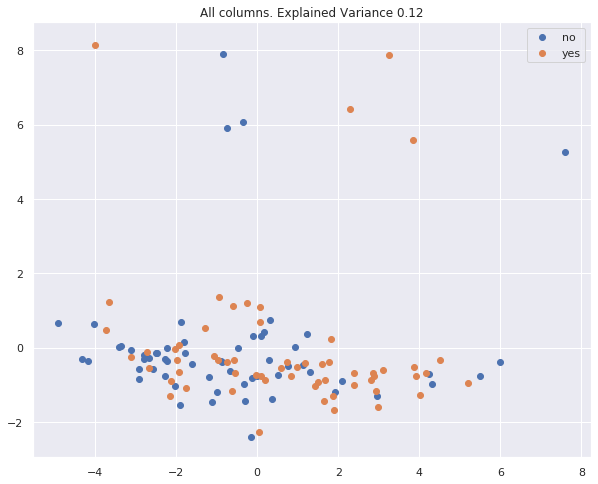

In [33]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(StandardScaler().fit_transform(X))

fig, ax = plt.subplots(figsize=(10, 8))

mask0 = y == 'No'
mask1 = y == 'Yes'
ax.scatter(Z_2d[mask0, 0], Z_2d[mask0, 1], label='no')
ax.scatter(Z_2d[mask1, 0], Z_2d[mask1, 1], label='yes')
ax.set_title(f'All columns. Explained Variance {pca.explained_variance_ratio_.sum():.2f}')
ax.legend()

### Imbalance Check

Check if the number of samples are balanced across classes.

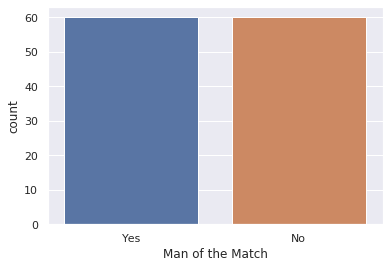

In [34]:
sns.countplot(y)

## Feature Engineering

Explore:
- Feature Selection
- Plot PCA

### SelectKBest

In [0]:
# Use classification test to find best features
# test checks each X with y
kbest = SelectKBest(f_classif, k='all')

X_kbest = kbest.fit(X, y)

### Tune best k

Plot the scores to find an "Elbow". This approach is similar to KMeans.

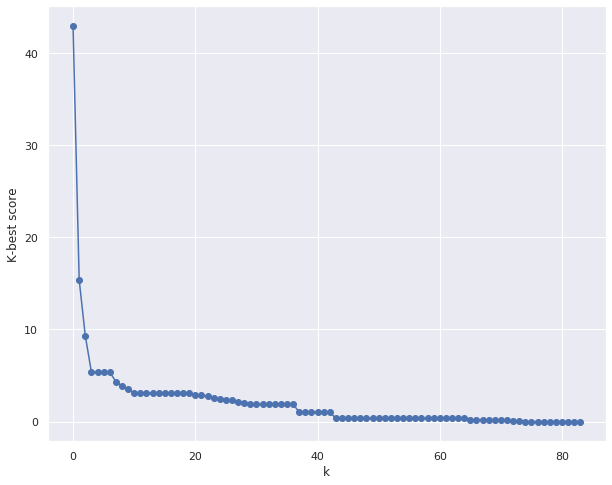

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))

# sort kbest scores in descending order
kbest_sorted = np.array(sorted(kbest.scores_, reverse=True))

# plot the sorted scores vs. k
ax.plot(kbest_sorted, marker='o')

ax.set_xlabel('k')
ax.set_ylabel('K-best score')

plt.show()

In [0]:
# Let's try k=10 (near elbow)
k = 10
kbest = SelectKBest(f_classif, k=k)

X_kbest = kbest.fit_transform(X, y)

In [38]:
X.columns[kbest.get_support()]

Index(['Goal Scored', 'Attempts', 'On-Target', 'Off-Target', 'Corners',
       '1st Goal', 'x0_Belgium', 'x0_France', 'x1_Belgium', 'x1_France'],
      dtype='object')

### Plot PCA with k-best features

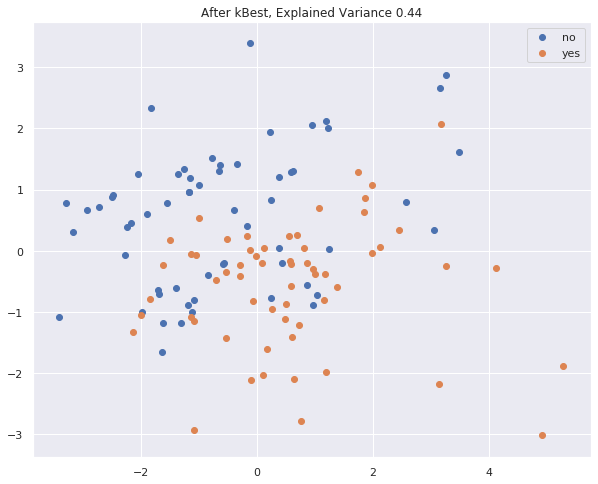

In [39]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(StandardScaler().fit_transform(X_kbest))

fig, ax = plt.subplots(figsize=(10, 8))

mask0 = y == 'No'
mask1 = y == 'Yes'
ax.scatter(Z_2d[mask0, 0], Z_2d[mask0, 1], label='no')
ax.scatter(Z_2d[mask1, 0], Z_2d[mask1, 1], label='yes')
ax.set_title(f'After kBest, Explained Variance {pca.explained_variance_ratio_.sum():.2f}')
ax.legend()
plt.show()

In [0]:
# Slightly better boundary of separation
# Why? Features that have low variance have been dropped

### Pipelining Data and Feature Engineering

- Train/test split not necessary because we have a separate test set (FIFA 2018 Statistics_train.csv, FIFA 2018 Statistics_test.csv)
  - However, we need to ensure the same processing steps are run with the train and test set
  - Let's put our pipeline together:
    1. Clean NaN
    2. LabelEncode
    3. Scale
    4. SelectKBest 

In [41]:
# we are going to fit again, so create a new one
column_transformer = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    (OneHotEncoder(drop='first'), columns_to_encode), # not supported by earlier versions of sklearn
    remainder='drop', verbose=True)

pipeline = Pipeline([
    ('clean', clean_nan_transformer),
    ('column_transform', column_transformer),
    ('kbest', SelectKBest(k=k))
])

pipeline

Pipeline(memory=None,
         steps=[('clean',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clean_nan at 0x7fe9f72deae8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('column_transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[(...
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,

In [0]:
# Verify that pipeline works
df_train = pd.read_csv(csv_path)
df_test = pd.read_csv(test_csv_path)

In [0]:
df_train_X = df_train.loc[:, df_train.columns != target]
df_train_y = df_train.loc[:, target]

In [0]:
df_test_X = df_test.loc[:, df_test.columns != target]
df_test_y = df_test.loc[:, target]

In [45]:
pipeline.fit_transform(df_train_X, df_train_y)

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s


<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 740 stored elements in Compressed Sparse Row format>

In [46]:
pipeline.transform(df_test_X)

<4x10 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

## Train a Decision Tree Classifier

We will complete the pipeline to add the Decision Tree Classifier

In [47]:
column_transformer = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    (OneHotEncoder(drop='first'), columns_to_encode),
    remainder='drop', verbose=True)

pipeline = Pipeline([
    ('clean', clean_nan_transformer),
    ('column_transform', column_transformer),
    ('kbest', SelectKBest(k=k)),
    
    # Add this
    ('dtc', DecisionTreeClassifier())
])

pipeline

Pipeline(memory=None,
         steps=[('clean',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clean_nan at 0x7fe9f72deae8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('column_transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[(...
                             score_func=<function f_classif at 0x7fe9fb0ced08>)),
                ('dtc',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=Non

In [48]:
# Fit completed pipeline to data
# Note that you cannot use cross_validate together with encoding, because
# the labels may not be present in each fold

pipeline.fit(df_train_X, df_train_y)

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s


Pipeline(memory=None,
         steps=[('clean',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clean_nan at 0x7fe9f72deae8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('column_transform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[(...
                             score_func=<function f_classif at 0x7fe9fb0ced08>)),
                ('dtc',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=Non

In [49]:
# Get predictions from completed pipeline

pred = pipeline.predict(df_test_X)
pred

array(['No', 'No', 'Yes', 'No'], dtype=object)

In [58]:
# Alternatively, if we want to perform cross validation
# Train decision tree classifier separately from pipeline...
pipeline_pre_training = Pipeline([
    ('clean', clean_nan_transformer),
    ('column_transform', column_transformer),
    ('kbest', SelectKBest(k=k)),
])

X_train = pipeline_pre_training.fit_transform(df_train_X, df_train_y)
X_test = pipeline_pre_training.transform(df_train_X)
X_train

[ColumnTransformer]  (1 of 2) Processing standardscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s


<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 740 stored elements in Compressed Sparse Row format>

In [59]:
# Then train decision tree using cross_validate as per usual

cv_results = cross_validate(DecisionTreeClassifier(), X_train, df_train_y,
                            cv = 3,
                            return_train_score=True, return_estimator=True)
cv_results

{'estimator': (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort=False,
                         random_state=None, splitter='best'),
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort=False,
                         random_state=None, splitter='best'),
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                         max_features=None, max_leaf_nodes=None,
        

In [0]:
# notice something about the train score?
# Decision trees overfit!

- Evaluation Metrics

In [50]:
print(classification_report(df_test_y, pred))

              precision    recall  f1-score   support

          No       0.67      1.00      0.80         2
         Yes       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



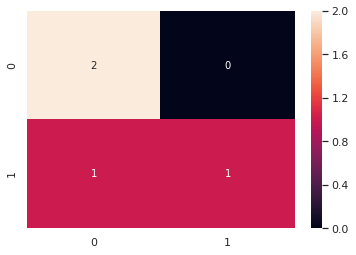

In [51]:
sns.heatmap(confusion_matrix(df_test_y, pred), annot=True)
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
plt.show()

- Feature Importances
  - Features that are used most often in the "best" split

In [52]:
# How to get the classifier from a pipeline
fitted_dtc = pipeline.named_steps['dtc']
fitted_dtc

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
# Features that result in the highest gain in purity
feat_impt = fitted_dtc.feature_importances_
feat_impt

array([0.04206349, 0.11328484, 0.0700983 , 0.10621972, 0.18884725,
       0.4096023 , 0.01616162, 0.0303346 , 0.02338788, 0.        ])

In [54]:
kbest_cols = X.columns[pipeline.named_steps['kbest'].get_support()]
kbest_cols

Index(['Goal Scored', 'Attempts', 'On-Target', 'Off-Target', 'Corners',
       '1st Goal', 'x0_Belgium', 'x0_France', 'x1_Belgium', 'x1_France'],
      dtype='object')

In [55]:
df_impt = pd.DataFrame(feat_impt, kbest_cols, columns=['Feat Impt'])
df_impt.sort_values(by='Feat Impt', ascending=False)

,Feat Impt
1st Goal,0.409602
Corners,0.188847
Attempts,0.113285
Off-Target,0.106220
On-Target,0.070098
Goal Scored,0.042063
x0_France,0.030335
x1_Belgium,0.023388
x0_Belgium,0.016162
x1_France,0.000000


### Visualise the Decision Tree

In [56]:
# Requires graphviz to be installed with class setup instructions

# if you get an error about dot, check that you don't have
# the old .pdf open somewhere

from sklearn.tree import export_graphviz
import graphviz

filename = 'dtc_fifa.dot'
export_graphviz(fitted_dtc,
                out_file=filename,
                feature_names=kbest_cols,
                filled=True,
                rounded=True)

source = graphviz.Source.from_file(filename)
source.render(view=True)

'dtc_fifa.dot.pdf'

In [0]:
# Try visualising the cross_validated Decision Tree
# Do we all get the same trees if we shuffle the dataset before training?